<a href="https://colab.research.google.com/github/Divyesh-Thirukonda/Conscientious-Cars/blob/main/SelfDrivingCars_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This week, we'll be delving right into the projects. 

You and your group are going to build an AI tool that can help self-driving cars see. 

It's like this!! (Click on the image!)

[<img src="https://i.ytimg.com/vi/2lxO_0FMalY/maxresdefault.jpg" width="500"/>](https://www.youtube.com/watch?v=9ydhDQaLAqM)

In this notebook we'll be:
1.   Understanding Object Detection for Self-driving cars
2.   Understanding our dataset
3.   Understanding and building Neural Networks
4.   Applying Neural Networks to Recognizing Vehicles


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

print("TensorFlow version: {}".format(tf.__version__))

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)
  
  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)
  
  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# Helper functions

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)    
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels      
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)  
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry. 
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
  ax.legend(loc = 1)    
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')
  
  plt.show()



TensorFlow version: 2.6.0


# Milestone 1. Understanding our task

## Exercise (Discussion) | Self-driving cars

We'll start by understanding our problem, identifying:
* What are potential benefits of self-driving cars? 
* How do self-driving cars work? 
* How do self-driving cars see? 

## Exercise (Discussion) | Object Detection


- Given an input image, what is the output of the object detection task?


- Can you break this problem into some subtasks?



Today, we'll first start from building a image classifier which can recognize cars.

# Milestone 2. Understanding our data

## Activity 1. What data do we have?

One commonly used dataset for object recognition is CIFAR10. There are 10 classes in CIFAR10, including airplane, car, bird, cat, deer, dog, frog, horse, ship, truck. 

As we are trying to build a image classifier for self-driving cars, detecting cars is more of interest to us. 

Therefore, here we use a vehicle dataset, which contains the images in the car and truck categories, as well as some randomly chosen images from other categories in the CIFAR10 dataset.

We use `load_vehicle_dataset()` to load the images in both the training set and the test set.



In [ ]:
(x_train, y_train), (x_test, y_test) = load_vehicle_dataset()

170508288/170498071 [==============================] - 2s 0us/step


Here, `x` contains the images and `y` contains the corresponding class labels. 

Let's first get a better understanding of the dataset by looking into the labels.

### Exercise 1

`y_train` and `y_test` are 2 numpy arrays of our images' labels.

The shape of a numpy array is stored in the `shape` attribute, so we can check the shape of the training set label by `y_train.shape`.

In [ ]:
print('Our labels are stored as %s in Python' % type(y_train))
print('The label vector of the training set has dimensions of (%d, )' % y_train.shape)
print('The label vector of the test set has dimensions of (%d, )' % y_test.shape)

Our labels are stored as <class 'numpy.ndarray'> in Python
The label vector of the training set has dimensions of (15000, )
The label vector of the test set has dimensions of (3000, )


Each object catogory is represented in a number as the label in the `y` vectors. 

Class names have been saved in the list `idx_to_class`, where the indices are the labels and the elements are class names. Eg. `idx_to_class[1]` is `car`, this means each `car` image has a label `1` in the `y` vector.

You can print the whole list to check the 3 classes we have in this dataset.

In [ ]:
### YOUR CODE HERE
print(idx_to_class)
### END CODE

['background', 'car', 'truck']


### Exercise 2

We also want to know how many images we have in each class. The `Counter` class in the `collections` package can count the occurrence of different elements for us. For example:

```
l = [1, 2, 3, 3, 4, 5, 5, 5]
counter = collections.Counter(l)
print(counter)
```

We can get:
```
Counter({5: 3, 3: 2, 1: 1, 2: 1, 4: 1})
```

Try to use this to check the number of images we have in each object category.

In [ ]:
import collections

### YOUR CODE HERE
counter = collections.Counter(y_train)
print(counter)
### END CODE

Counter({0: 5000, 1: 5000, 2: 5000})


## Activity 2. What does our data look like? 

Next, let's take a look at the images in the dataset.

### Exercise 3

The images in the training and test sets are stored as numpy arrays in `x_train` and `x_test` respectively. 

Can you get the shape of these 2 arrays as what we did on the labels?

In [ ]:
### YOUR CODE HERE
print(x_train.shape)
print(x_test.shape)
### END CODE

(15000, 32, 32, 3)
(3000, 32, 32, 3)


In [ ]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**15000**, 32, 32, 3) represent? 
Dimension_0  = "number of images" #@param ["number of images", "image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (15000, **32**, 32, 3) represent? 
Dimension_1  = "image height" #@param ["number of images", "image width", "image height","number of colors","fill in"]
  
#@markdown What does the bold number (15000, 32, **32**, 3) represent? 
Dimension_2  = "image width" #@param ["number of images", "image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (15000, 32, 32, **3**) represent? 
Dimension_3  = "number of colors" #@param ["number of images", "image width", "image height","number of colors","fill in"]

if Dimension_0 == 'number of images':
  print("Yes! Dimension_0 is the number of images.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image height':
  print("Yes! Dimension_1 is the height of the image.")
else:
  print("Try again for Dimension_1!")

if Dimension_2 == 'image width':
  print("Yes! Dimension_2 is the width of the image.")
else:
  print("Try again for Dimension_2!")
  
if Dimension_3 == 'number of colors':
  print("Yes! Dimension_3 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_3!")


Yes! Dimension_0 is the number of images.
Yes! Dimension_1 is the height of the image.
Yes! Dimension_2 is the width of the image.
Yes! Dimension_3 stands for 3 colors - (r,g,b).


### Exercise 4

Remember our `plot_one_image` function from last week? We'll use that with our data to view our images! Let's see a single image. 

`plot_one_image` can take in either one image or many images. 

```
plot_one_image(data, labels)
```

where:
* `data`: 1 or more images in one array
* `labels`: the labels corresponding to the images in a list


Label: ['background']


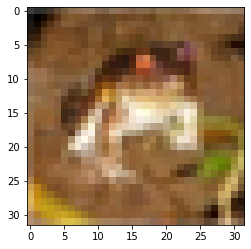

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
plot_one_image(x_train[0], [idx_to_class[y_train[0]]])
### END CODE

Next, let's build an classifier using neural networks!

# Milestone 3. Understanding and building Neural Networks (Perceptron)

### What are neural networks?

Just as we went over last week, neural networks look something like this: 
![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. 

**In terms of this problem, what do each of the 4 blue neurons correspond to?**

## Activity 1. Building networks

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

Tensorflow calls the various machine learning algorithms that it uses 'models'.  These 'models' are 'learning machines.''

1. We **teach** models by **training** them on **data**. 
2. We **use** models to **predict** things. 


In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

Before we train the model or use it to predict something, we have to **create** the model. 

In [ ]:
# create our model by specifying and compiling it
model = Sequential()
model.add(Dense(4, input_shape=(3,),activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

The things you'll want to pay most attention to as we go over how to build networks are: 
1. The number of neurons
2. The activation of the neurons
3. The losses and metrics

Everything else will work with the default settings!

Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```


To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```

You can actually use the model before you even train it! It just won't perform very well. 

### Exercise (Coding): A 2-Layer Model



We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [ ]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape=(3,),activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
### END CODE

In [ ]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'softmax'))
model_1_answer.compile(loss='categorical_crossentropy',
optimizer = 'adam', 
metrics = ['accuracy'])

if model_to_string(model_1) == model_to_string(model_1_answer):
  print('Good job! Your model worked')
else: 
  print('Please check your code again!')

Good job! Your model worked


# Milestone 4. Applying Neural Networks to Recognizing Vehicles


## Instructor-Led Discussion: Model Architecture


In our problem, we are given `images` of shape `(32, 32, 3)`, each assigned to one of 3 labels: car, truck, others. We want to identify the key things that we need to design our network. 

In your group, discuss: 

* What are our inputs?
* What is/are our outputs?
* How could this look in a neural network diagram?



## Activity 1. Building our custom neural network

### Key Points 

We will build a simple 2-layer network for our first model!


For our model, we have as our layers: 
* Input Layer:  However many inputs there are!
* Layer 1 (Hidden): 128 neurons that are activated by `'relu'`
* Layer 2 (Output): 3 neurons (1 per possible predicted class) that should have an appropriate activation. 
* We will compile with the `optimizers.SGD(lr=1e-3, momentum=0.9)` optimizer

As a hint for the output activation and the compilation loss, we know that:
* Binary classification problems require an output activation of `'sigmoid'` and a loss of `'binary_cross_entropy'`
* Multi-class classification problems require an output activation of `'softmax'` and a loss of `'categorical_crossentropy'`
* Linear regression problems require an output activation of `'linear'` and a loss of `'mean_squared_error'`




###Build Your Model

Remember the transformation you need to apply to your input (hint: flattening) in order to make it work with a multi-layer perceptron!

In [ ]:
perceptron = Sequential()
### FILL IN YOUR CODE HERE
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(400, input_shape=(3,),activation = 'relu'))
perceptron.add(Dense(128, input_shape=(3,),activation = 'relu'))
perceptron.add(Dense(3, activation = 'softmax'))
perceptron.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                metrics=['accuracy'])
### END CODE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#@title Run this to test if your model is right! { display-mode: "form" }
perceptron_answer = Sequential()
perceptron_answer.add(Flatten(input_shape = (32, 32, 3)))
perceptron_answer.add(Dense(units = 128, activation = 'relu'))
perceptron_answer.add(Dense(units = 3, activation = 'softmax'))
    
perceptron_answer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

if model_to_string(perceptron) == model_to_string(perceptron_answer):
  print('Good job, you specified it correctly!')
else: 
  print('Please check your code again!')

Good job, you specified it correctly!


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Exercise (Coding)



Let's now train our perceptron on images from the train data! 

Unlike the models that we used in sklearn, our neural networks are pretty finnicky. Their performance depends a lot on *how much* they train. As we'll see, they usually get better with more training BUT actually can get worse with too much training. With too much training, our model can get overconfident in its abilities with the training manual (overfitting), and so doesn't actually think (generalize) when it is tested. 

The extra options in our `fit()` function pertain to how the neural networks train. Don't worry too much about the extra options, what really matters for us is that the right data is specified.

To use `fit`, we use the following code:
```
history = perceptron.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```
What are all these options?
* `epochs`: how many times the model trains on the entire data set
* `shuffle`: mixes the training dataset so the model pays better attention to the data and learns better while training
* `validation_data`: we request that our model tests itself on the `test_data` after every epoch. Since our model is finnicky, instead of testing our model at the end of the training, we test it throughout. 

 `history` gives us a data structure which allows us to plot the training and validation accuracy over time.

We have one more option too:
* `callbacks`: With a custom command, we tell our model to save the best version of itself to a model file called `model.h5`. 


Let's try this out!

**Specifically, load in the training and testing data and then train your MLP model.**


Before training the model, we need to preprocess the data for better training. 
Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. We have implemented this in the `normalize(input_data)` for you.

Besides, we need to convert the label for each image into a one-hot vector, which means, for example, we represent label 2 (truck) as a vector `[0, 0, 1]`, so that the model output can be directly compared with the data label. This has been implemented in the `label_to_onehot(labels)` function.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# define our monitor. Don't worry about the parameters here except for './model.h5' which is the file that our model saves to 
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Normalize the data.
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

# Convert labels into one-hot numpy arrays.
y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

### YOUR CODE HERE
history = perceptron.fit(x_train_norm, y_train_onehot, epochs = 10, validation_data = (x_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])

### END CODE

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.8285 - accuracy: 0.6425 - val_loss: 0.7765 - val_accuracy: 0.6587
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.6323 - accuracy: 0.7401 - val_loss: 0.6979 - val_accuracy: 0.7087
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.5409 - accuracy: 0.7835 - val_loss: 0.6746 - val_accuracy: 0.7137
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.4658 - accuracy: 0.8205 - val_loss: 0.6722 - val_accuracy: 0.7270
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3961 - accuracy: 0.8514 - val_loss: 0.6790 - val_accuracy: 0.7220
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.3342 - accuracy: 0.8818 - val_loss: 0.7152 - val_accuracy: 0.7253
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.2800 - accuracy: 0.9050 - val_loss: 0.7191 - val_accuracy: 0.7203

As our model trained, it told us a few things. The most important things to us are:
* how accurate it was when training on the training set (reported as `acc`) 
* how accurate it was on the test set (reported as `val_acc`)


We can actually plot how how well our model did across epochs using the model's `history`!
To do this, we call:
```
plot_acc(history)
```

Try `plot_acc` below!

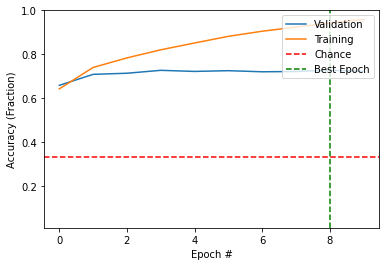

In [ ]:
### YOUR CODE HERE

plot_acc(history)
### END CODE

## Instructor-Led Discussion

Is this a good model? Does your model overfit? How do you know?